# Klasifikasi Pesan Spam pada SMS Berbahasa Indonesia Menggunakan IndoBERT

## Deskripsi
Notebook ini mengimplementasikan sistem klasifikasi SMS spam/ham (legitimate) berbahasa Indonesia menggunakan model deep learning IndoBERT.

**Dataset:** `dataset_sms_spam_v1.csv`
- Label 0 = Normal/Ham (pesan legitimate)
- Label 1 = Spam Penipuan
- Label 2 = Spam Promosi/Iklan

**Model:** IndoBERT (indobenchmark/indobert-base-p1)
- Pre-trained BERT model khusus Bahasa Indonesia
- Fine-tuned untuk task binary classification

## 1. Install Dependencies (Jalankan jika belum terinstall)

In [1]:
# Install libraries yang dibutuhkan
# Uncomment dan jalankan jika belum terinstall
# !pip install transformers torch datasets accelerate sentencepiece pandas numpy matplotlib seaborn scikit-learn tqdm

## 2. Import Libraries

In [2]:
# Data processing
import pandas as pd
import numpy as np
import re
import warnings
warnings.filterwarnings('ignore')

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# PyTorch
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torch.optim import AdamW

# Transformers (Hugging Face)
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    get_linear_schedule_with_warmup
)

# Scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    accuracy_score,
    precision_recall_fscore_support
)

# Progress bar
from tqdm.auto import tqdm

# Set random seeds
np.random.seed(42)
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(42)

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"🚀 Using device: {device}")
if torch.cuda.is_available():
    print(f"   GPU: {torch.cuda.get_device_name(0)}")
    print(f"   Memory: {torch.cuda.get_device_properties(0).total_memory / 1024**3:.2f} GB")

print("\n✅ Libraries berhasil di-import!")

🚀 Using device: cpu

✅ Libraries berhasil di-import!


## 3. Load dan Explore Dataset

In [4]:
# Load dataset
df = pd.read_csv('dataset\dataset_sms_spam_v1.csv')

print(f"Dataset shape: {df.shape}")
print(f"\nKolom dataset: {df.columns.tolist()}")
print(f"\nInfo dataset:")
df.info()

Dataset shape: (1143, 2)

Kolom dataset: ['Teks', 'label']

Info dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1143 entries, 0 to 1142
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Teks    1143 non-null   object
 1   label   1143 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 18.0+ KB


In [5]:
# Preview data
df.head(10)

,Teks,label
0,[PROMO] Beli paket Flash mulai 1GB di MY TELKO...,2
1,2.5 GB/30 hari hanya Rp 35 Ribu Spesial buat A...,2
2,"2016-07-08 11:47:11.Plg Yth, sisa kuota Flash ...",2
3,"2016-08-07 11:29:47.Plg Yth, sisa kuota Flash ...",2
4,4.5GB/30 hari hanya Rp 55 Ribu Spesial buat an...,2
5,5 HARI LAGI ! EKSTRA Pulsa 50rb dg beli paket ...,2
6,"Ada iRing dgn tarif Rp. 0,1/7hr (perpanjangan ...",2
7,Akhir bulan harus tetap eksis loh! Internetan ...,2
8,Aktifkan iRing Coboy Jr - Terhebat. Tekan *808...,2
9,Ambil bonus harianmu di *600# (Bebas Pulsa). D...,2


Distribusi Label:
label
0    569
1    335
2    239
Name: count, dtype: int64

Persentase:
label
0    49.781277
1    29.308836
2    20.909886
Name: proportion, dtype: float64


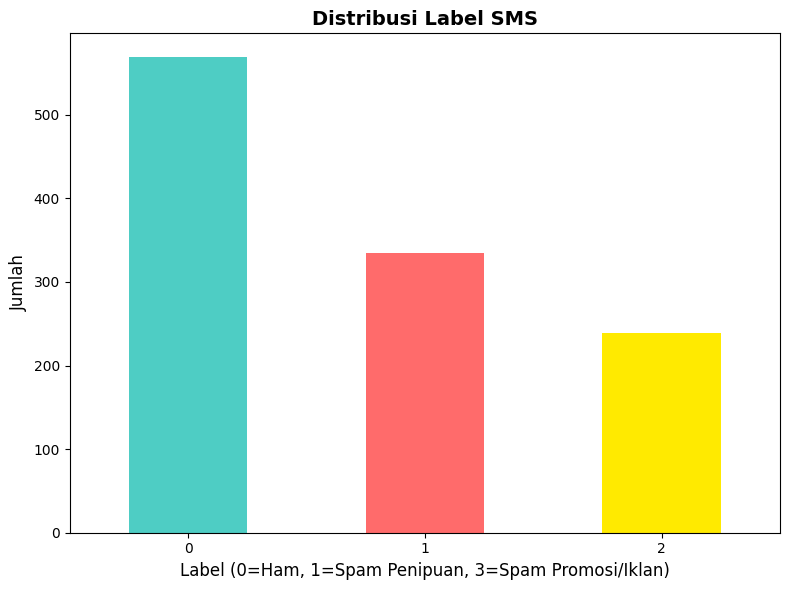

In [7]:
# Cek distribusi label
print("Distribusi Label:")
print(df['label'].value_counts())
print(f"\nPersentase:")
print(df['label'].value_counts(normalize=True) * 100)

# Visualisasi distribusi
plt.figure(figsize=(8, 6))
df['label'].value_counts().plot(kind='bar', color=['#4ECDC4', '#FF6B6B', '#FFEA00'])
plt.title('Distribusi Label SMS', fontsize=14, fontweight='bold')
plt.xlabel('Label (0=Ham, 1=Spam Penipuan, 3=Spam Promosi/Iklan)', fontsize=12)
plt.ylabel('Jumlah', fontsize=12)
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

In [8]:
# Cek missing values
print("Missing Values:")
print(df.isnull().sum())

# Drop missing values jika ada
df = df.dropna()
print(f"\nDataset setelah drop missing: {df.shape}")

Missing Values:
Teks     0
label    0
dtype: int64

Dataset setelah drop missing: (1143, 2)


## 4. Preprocessing Data

In [9]:
# Rename kolom untuk konsistensi
df.rename(columns={'Teks': 'text', 'label': 'label'}, inplace=True)

# Cek unique label values terlebih dahulu
print("Unique label values:", sorted(df['label'].unique()))
print("\nLabel distribution sebelum mapping:")
print(df['label'].value_counts())

# PERBAIKAN MAPPING:
# Berdasarkan analisis sample data:
# - Label 0 = Ham (pesan normal/personal)
# - Label 1 = Spam (penawaran/iklan komersial) 
# - Label 2 = Spam (promo operator)
# Jadi: 0 → Ham (0), 1 & 2 → Spam (1)
df['label'] = df['label'].apply(lambda x: 0 if x == 0 else 1)

print("\n=== Setelah Mapping ===")
print("\nLabel distribution setelah mapping:")
print(df['label'].value_counts())
print("\nPersentase:")
print(df['label'].value_counts(normalize=True) * 100)

# Cek tidak ada NaN
print(f"\nCek NaN: {df['label'].isna().sum()} (harus 0)")

Unique label values: [np.int64(0), np.int64(1), np.int64(2)]

Label distribution sebelum mapping:
label
0    569
1    335
2    239
Name: count, dtype: int64

=== Setelah Mapping ===

Label distribution setelah mapping:
label
1    574
0    569
Name: count, dtype: int64

Persentase:
label
1    50.218723
0    49.781277
Name: proportion, dtype: float64

Cek NaN: 0 (harus 0)


In [41]:
# Function untuk text cleaning
def clean_text(text):
    """Membersihkan teks dari karakter tidak perlu"""
    text = str(text)
    # Lowercase
    text = text.lower()
    # Remove URLs
    text = re.sub(r'http\S+|www\S+|https\S+', ' ', text, flags=re.MULTILINE)
    # Remove extra whitespace
    text = re.sub(r'\s+', ' ', text).strip()
    return text

# Apply cleaning
df['clean_text'] = df['text'].apply(clean_text)

print("Contoh text sebelum dan sesudah cleaning:\n")
print("Sebelum:")
print(df['text'].iloc[0])
print("\nSesudah:")
print(df['clean_text'].iloc[0])

Contoh text sebelum dan sesudah cleaning:

Sebelum:
[PROMO] Beli paket Flash mulai 1GB di MY TELKOMSEL APP dpt EXTRA kuota 2GB 4G LTE dan EXTRA nelpon hingga 100mnt/1hr. Buruan, cek  di tsel.me/mytsel1 S&K

Sesudah:
[promo] beli paket flash mulai 1gb di my telkomsel app dpt extra kuota 2gb 4g lte dan extra nelpon hingga 100mnt/1hr. buruan, cek di tsel.me/mytsel1 s&k


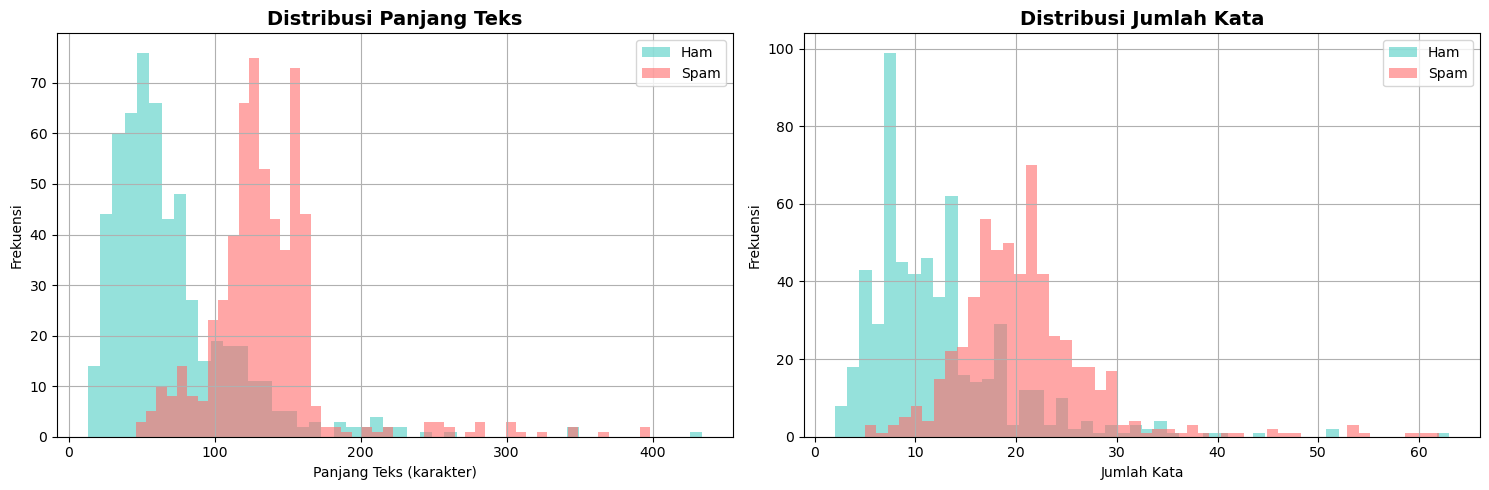


Statistik Panjang Teks per Label:
      text_length                                                           \
            count        mean        std   min    25%    50%    75%    max   
label                                                                        
0           569.0   70.347979  46.111452  13.0   42.0   59.0   83.0  434.0   
1           574.0  135.435540  42.524054  46.0  116.0  131.0  153.0  398.0   

      word_count                                                    
           count       mean       std  min   25%   50%   75%   max  
label                                                               
0          569.0  12.114236  7.231773  2.0   7.0  11.0  14.0  63.0  
1          574.0  20.879791  7.027583  5.0  17.0  20.0  24.0  62.0  


In [42]:
# Statistik panjang teks
df['text_length'] = df['clean_text'].str.len()
df['word_count'] = df['clean_text'].str.split().str.len()

fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Distribusi panjang teks per label
df[df['label'] == 0]['text_length'].hist(bins=50, alpha=0.6, label='Ham', ax=axes[0], color='#4ECDC4')
df[df['label'] == 1]['text_length'].hist(bins=50, alpha=0.6, label='Spam', ax=axes[0], color='#FF6B6B')
axes[0].set_title('Distribusi Panjang Teks', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Panjang Teks (karakter)')
axes[0].set_ylabel('Frekuensi')
axes[0].legend()

# Distribusi jumlah kata per label
df[df['label'] == 0]['word_count'].hist(bins=50, alpha=0.6, label='Ham', ax=axes[1], color='#4ECDC4')
df[df['label'] == 1]['word_count'].hist(bins=50, alpha=0.6, label='Spam', ax=axes[1], color='#FF6B6B')
axes[1].set_title('Distribusi Jumlah Kata', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Jumlah Kata')
axes[1].set_ylabel('Frekuensi')
axes[1].legend()

plt.tight_layout()
plt.show()

print("\nStatistik Panjang Teks per Label:")
print(df.groupby('label')[['text_length', 'word_count']].describe())

## 5. Load IndoBERT Tokenizer

In [43]:
# Load IndoBERT tokenizer
MODEL_NAME = 'indobenchmark/indobert-base-p1'

print(f"Loading tokenizer: {MODEL_NAME}...")
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
print("✅ Tokenizer loaded!")

Loading tokenizer: indobenchmark/indobert-base-p1...
✅ Tokenizer loaded!
✅ Tokenizer loaded!


In [44]:
# Test tokenizer
sample_text = df['clean_text'].iloc[0]
tokens = tokenizer.tokenize(sample_text)

print(f"Sample text: {sample_text}\n")
print(f"Tokens ({len(tokens)}): {tokens[:20]}...")

# Encode
encoded = tokenizer.encode_plus(
    sample_text,
    add_special_tokens=True,
    max_length=128,
    padding='max_length',
    truncation=True,
    return_tensors='pt'
)

print(f"\nEncoded input_ids shape: {encoded['input_ids'].shape}")
print(f"Encoded attention_mask shape: {encoded['attention_mask'].shape}")

Sample text: [promo] beli paket flash mulai 1gb di my telkomsel app dpt extra kuota 2gb 4g lte dan extra nelpon hingga 100mnt/1hr. buruan, cek di tsel.me/mytsel1 s&k

Tokens (48): ['[', 'promo', ']', 'beli', 'paket', 'flash', 'mulai', '1', '##gb', 'di', 'my', 'telkomsel', 'app', 'dpt', 'extra', 'kuota', '2', '##gb', '4', '##g']...

Encoded input_ids shape: torch.Size([1, 128])
Encoded attention_mask shape: torch.Size([1, 128])


## 6. Prepare Dataset untuk PyTorch

In [45]:
# Hyperparameters
MAX_LENGTH = 128      # Maximum sequence length
BATCH_SIZE = 16       # Batch size (turunkan jika GPU memory terbatas)
EPOCHS = 3            # Number of training epochs
LEARNING_RATE = 2e-5  # Learning rate

print(f"Hyperparameters:")
print(f"  - Max Length: {MAX_LENGTH}")
print(f"  - Batch Size: {BATCH_SIZE}")
print(f"  - Epochs: {EPOCHS}")
print(f"  - Learning Rate: {LEARNING_RATE}")

Hyperparameters:
  - Max Length: 128
  - Batch Size: 16
  - Epochs: 3
  - Learning Rate: 2e-05


In [46]:
# Split dataset: 70% train, 15% val, 15% test
train_texts, temp_texts, train_labels, temp_labels = train_test_split(
    df['clean_text'].values,
    df['label'].values,
    test_size=0.3,
    random_state=42,
    stratify=df['label'].values
)

val_texts, test_texts, val_labels, test_labels = train_test_split(
    temp_texts,
    temp_labels,
    test_size=0.5,
    random_state=42,
    stratify=temp_labels
)

print(f"Dataset split:")
print(f"  - Training: {len(train_texts)} samples")
print(f"  - Validation: {len(val_texts)} samples")
print(f"  - Test: {len(test_texts)} samples")

# Check distribution
print(f"\nLabel distribution:")
print(f"  Train - Ham: {(train_labels == 0).sum()}, Spam: {(train_labels == 1).sum()}")
print(f"  Val   - Ham: {(val_labels == 0).sum()}, Spam: {(val_labels == 1).sum()}")
print(f"  Test  - Ham: {(test_labels == 0).sum()}, Spam: {(test_labels == 1).sum()}")

Dataset split:
  - Training: 800 samples
  - Validation: 171 samples
  - Test: 172 samples

Label distribution:
  Train - Ham: 398, Spam: 402
  Val   - Ham: 85, Spam: 86
  Test  - Ham: 86, Spam: 86


In [47]:
# Custom Dataset Class
class SMSDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length
    
    def __len__(self):
        return len(self.texts)
    
    def __getitem__(self, idx):
        text = str(self.texts[idx])
        label = self.labels[idx]
        
        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_length,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        )
        
        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }

# Create datasets
train_dataset = SMSDataset(train_texts, train_labels, tokenizer, MAX_LENGTH)
val_dataset = SMSDataset(val_texts, val_labels, tokenizer, MAX_LENGTH)
test_dataset = SMSDataset(test_texts, test_labels, tokenizer, MAX_LENGTH)

# Create dataloaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE)

print("✅ Datasets dan DataLoaders berhasil dibuat!")
print(f"\nJumlah batch per epoch:")
print(f"  - Training: {len(train_loader)} batches")
print(f"  - Validation: {len(val_loader)} batches")
print(f"  - Test: {len(test_loader)} batches")

✅ Datasets dan DataLoaders berhasil dibuat!

Jumlah batch per epoch:
  - Training: 50 batches
  - Validation: 11 batches
  - Test: 11 batches


## 7. Initialize IndoBERT Model

In [48]:
# Load pre-trained IndoBERT model for classification
num_labels = 2  # Binary classification (ham/spam)

print(f"Loading IndoBERT model: {MODEL_NAME}...")
model = AutoModelForSequenceClassification.from_pretrained(
    MODEL_NAME,
    num_labels=num_labels
)

model = model.to(device)
print(f"✅ Model loaded dan dipindahkan ke {device}!")

# Count parameters
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"\nModel Statistics:")
print(f"  - Total parameters: {total_params:,}")
print(f"  - Trainable parameters: {trainable_params:,}")

Loading IndoBERT model: indobenchmark/indobert-base-p1...


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


✅ Model loaded dan dipindahkan ke cuda!

Model Statistics:
  - Total parameters: 124,442,882
  - Trainable parameters: 124,442,882


## 8. Setup Optimizer dan Scheduler

In [49]:
# Optimizer
optimizer = AdamW(model.parameters(), lr=LEARNING_RATE)

# Learning rate scheduler
total_steps = len(train_loader) * EPOCHS
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps=total_steps
)

print(f"✅ Optimizer dan scheduler berhasil dibuat!")
print(f"   Total training steps: {total_steps}")

✅ Optimizer dan scheduler berhasil dibuat!
   Total training steps: 150


## 9. Training dan Evaluation Functions

In [50]:
def train_epoch(model, data_loader, optimizer, device, scheduler):
    """Train model for one epoch"""
    model.train()
    losses = []
    correct_predictions = 0
    
    progress_bar = tqdm(data_loader, desc='Training')
    
    for batch in progress_bar:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)
        
        # Forward pass
        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask,
            labels=labels
        )
        
        loss = outputs.loss
        logits = outputs.logits
        
        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        scheduler.step()
        
        # Calculate accuracy
        _, preds = torch.max(logits, dim=1)
        correct_predictions += torch.sum(preds == labels)
        losses.append(loss.item())
        
        # Update progress bar
        progress_bar.set_postfix({'loss': loss.item()})
    
    return correct_predictions.double() / len(data_loader.dataset), np.mean(losses)


def eval_model(model, data_loader, device):
    """Evaluate model"""
    model.eval()
    losses = []
    correct_predictions = 0
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for batch in tqdm(data_loader, desc='Evaluating'):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)
            
            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask,
                labels=labels
            )
            
            loss = outputs.loss
            logits = outputs.logits
            
            _, preds = torch.max(logits, dim=1)
            correct_predictions += torch.sum(preds == labels)
            losses.append(loss.item())
            
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    return (
        correct_predictions.double() / len(data_loader.dataset),
        np.mean(losses),
        np.array(all_preds),
        np.array(all_labels)
    )

print("✅ Training dan evaluation functions ready!")

✅ Training dan evaluation functions ready!


## 10. Training Model

In [51]:
# Training history
history = {
    'train_acc': [],
    'train_loss': [],
    'val_acc': [],
    'val_loss': []
}

best_val_acc = 0

print("🚀 Starting training...\n")
print("=" * 80)

for epoch in range(EPOCHS):
    print(f"\nEpoch {epoch + 1}/{EPOCHS}")
    print("-" * 80)
    
    # Train
    train_acc, train_loss = train_epoch(
        model,
        train_loader,
        optimizer,
        device,
        scheduler
    )
    
    print(f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f}")
    
    # Validate
    val_acc, val_loss, val_preds, val_labels = eval_model(model, val_loader, device)
    print(f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f}")
    
    # Save history
    history['train_acc'].append(train_acc.item())
    history['train_loss'].append(train_loss)
    history['val_acc'].append(val_acc.item())
    history['val_loss'].append(val_loss)
    
    # Save best model
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), 'best_sms_spam_indobert.pt')
        print(f"✅ Best model saved! (Val Acc: {val_acc:.4f})")

print("\n" + "=" * 80)
print("✅ Training completed!")
print(f"Best validation accuracy: {best_val_acc:.4f}")

🚀 Starting training...


Epoch 1/3
--------------------------------------------------------------------------------


Training:   0%|          | 0/50 [00:00<?, ?it/s]

Train Loss: 0.1918 | Train Acc: 0.9500


Evaluating:   0%|          | 0/11 [00:00<?, ?it/s]

Val Loss: 0.0587 | Val Acc: 0.9825
✅ Best model saved! (Val Acc: 0.9825)

Epoch 2/3
--------------------------------------------------------------------------------
✅ Best model saved! (Val Acc: 0.9825)

Epoch 2/3
--------------------------------------------------------------------------------


Training:   0%|          | 0/50 [00:00<?, ?it/s]

Train Loss: 0.0626 | Train Acc: 0.9863


Evaluating:   0%|          | 0/11 [00:00<?, ?it/s]

Val Loss: 0.0615 | Val Acc: 0.9825

Epoch 3/3
--------------------------------------------------------------------------------


Training:   0%|          | 0/50 [00:00<?, ?it/s]

Train Loss: 0.0222 | Train Acc: 0.9925


Evaluating:   0%|          | 0/11 [00:00<?, ?it/s]

Val Loss: 0.0612 | Val Acc: 0.9825

✅ Training completed!
Best validation accuracy: 0.9825


## 11. Visualisasi Training History

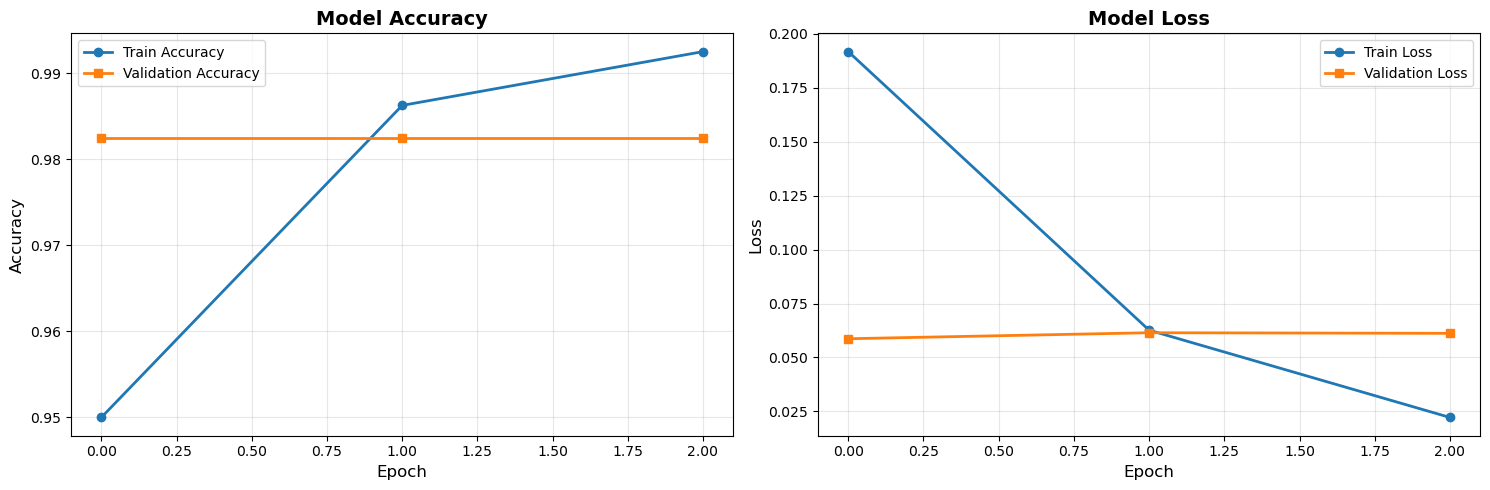

✅ Training history plot saved as 'training_history_sms_spam.png'


In [52]:
# Plot training history
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Accuracy plot
ax1.plot(history['train_acc'], label='Train Accuracy', marker='o', linewidth=2)
ax1.plot(history['val_acc'], label='Validation Accuracy', marker='s', linewidth=2)
ax1.set_xlabel('Epoch', fontsize=12)
ax1.set_ylabel('Accuracy', fontsize=12)
ax1.set_title('Model Accuracy', fontsize=14, fontweight='bold')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Loss plot
ax2.plot(history['train_loss'], label='Train Loss', marker='o', linewidth=2)
ax2.plot(history['val_loss'], label='Validation Loss', marker='s', linewidth=2)
ax2.set_xlabel('Epoch', fontsize=12)
ax2.set_ylabel('Loss', fontsize=12)
ax2.set_title('Model Loss', fontsize=14, fontweight='bold')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('training_history_sms_spam.png', dpi=300, bbox_inches='tight')
plt.show()

print("✅ Training history plot saved as 'training_history_sms_spam.png'")

## 12. Evaluasi pada Test Set

In [53]:
# Load best model
model.load_state_dict(torch.load('best_sms_spam_indobert.pt'))
model = model.to(device)
print("✅ Best model loaded!")

# Evaluate on test set
test_acc, test_loss, y_pred, y_true = eval_model(model, test_loader, device)

print(f"\n📊 Test Results:")
print(f"   Test Loss: {test_loss:.4f}")
print(f"   Test Accuracy: {test_acc:.4f}")

✅ Best model loaded!


Evaluating:   0%|          | 0/11 [00:00<?, ?it/s]


📊 Test Results:
   Test Loss: 0.0918
   Test Accuracy: 0.9767


In [54]:
# Classification Report
print("\n📊 Classification Report:")
print("=" * 80)
print(classification_report(
    y_true,
    y_pred,
    target_names=['Ham (Normal)', 'Spam'],
    digits=4
))

# Calculate additional metrics
precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred, average='binary')

print(f"\n📈 Summary Metrics:")
print(f"   Accuracy:  {test_acc:.4f}")
print(f"   Precision: {precision:.4f}")
print(f"   Recall:    {recall:.4f}")
print(f"   F1-Score:  {f1:.4f}")


📊 Classification Report:
              precision    recall  f1-score   support

Ham (Normal)     1.0000    0.9535    0.9762        86
        Spam     0.9556    1.0000    0.9773        86

    accuracy                         0.9767       172
   macro avg     0.9778    0.9767    0.9767       172
weighted avg     0.9778    0.9767    0.9767       172


📈 Summary Metrics:
   Accuracy:  0.9767
   Precision: 0.9556
   Recall:    1.0000
   F1-Score:  0.9773


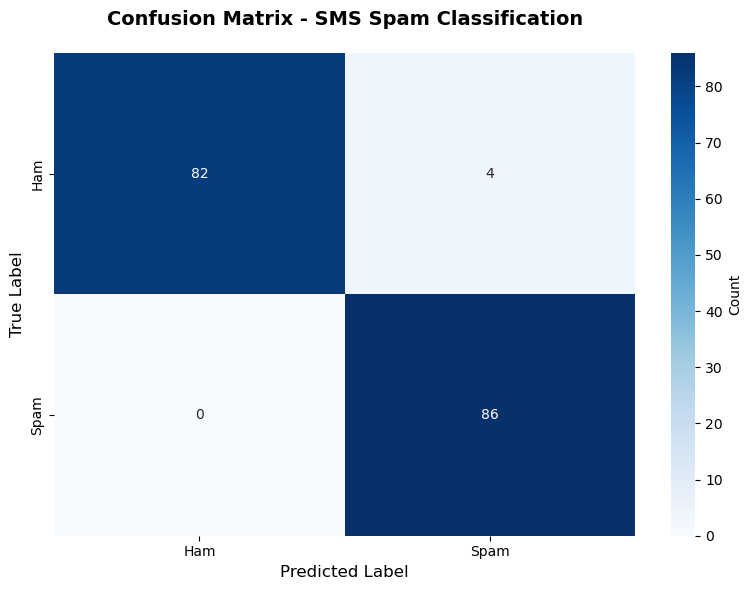


Per-Class Accuracy:
Ham: 0.9535
Spam: 1.0000


In [55]:
# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(
    cm,
    annot=True,
    fmt='d',
    cmap='Blues',
    xticklabels=['Ham', 'Spam'],
    yticklabels=['Ham', 'Spam'],
    cbar_kws={'label': 'Count'}
)
plt.title('Confusion Matrix - SMS Spam Classification', fontsize=14, fontweight='bold', pad=20)
plt.xlabel('Predicted Label', fontsize=12)
plt.ylabel('True Label', fontsize=12)
plt.tight_layout()
plt.savefig('confusion_matrix_sms_spam.png', dpi=300, bbox_inches='tight')
plt.show()

# Per-class accuracy
print("\nPer-Class Accuracy:")
print("=" * 50)
for i, label_name in enumerate(['Ham', 'Spam']):
    class_acc = cm[i, i] / cm[i].sum() if cm[i].sum() > 0 else 0
    print(f"{label_name}: {class_acc:.4f}")

## 13. Prediction Function untuk SMS Baru

In [56]:
def predict_sms(text, model, tokenizer, device, max_length=128):
    """Predict apakah SMS adalah spam atau ham"""
    model.eval()
    
    # Clean text
    text = clean_text(text)
    
    # Tokenize
    encoding = tokenizer.encode_plus(
        text,
        add_special_tokens=True,
        max_length=max_length,
        padding='max_length',
        truncation=True,
        return_attention_mask=True,
        return_tensors='pt'
    )
    
    input_ids = encoding['input_ids'].to(device)
    attention_mask = encoding['attention_mask'].to(device)
    
    # Predict
    with torch.no_grad():
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        logits = outputs.logits
    
    # Get probabilities
    probs = torch.softmax(logits, dim=1)
    confidence, predicted_class = torch.max(probs, dim=1)
    
    label_name = 'Ham (Normal)' if predicted_class.item() == 0 else 'Spam'
    
    return {
        'label': label_name,
        'class': predicted_class.item(),
        'confidence': confidence.item(),
        'probabilities': {
            'ham': probs[0][0].item(),
            'spam': probs[0][1].item()
        }
    }

print("✅ Prediction function ready!")

✅ Prediction function ready!


In [57]:
# Test dengan SMS baru
test_messages = [
    "GRATIS pulsa 100rb!! Buruan klik link ini sekarang juga!",
    "Halo, meeting kita jam 2 siang ya di kantor. Jangan lupa bawa dokumen.",
    "PROMO SPESIAL! Beli 1 GRATIS 1. Hanya hari ini. Hub *123# sekarang!",
    "Pak, saya sudah kirim laporan lewat email. Mohon dicek ya.",
    "Dapatkan BONUS PULSA 50rb dengan isi ulang minimal 10rb. Ketik YA kirim ke 123"
]

print("🧪 Testing dengan SMS Baru:\n")
print("=" * 100)

for i, sms in enumerate(test_messages, 1):
    result = predict_sms(sms, model, tokenizer, device)
    
    print(f"\n{i}. SMS:")
    print(f"   {sms}")
    print(f"\n   Prediksi: {result['label']}")
    print(f"   Confidence: {result['confidence']:.2%}")
    print(f"   Probabilitas:")
    print(f"     - Ham:  {result['probabilities']['ham']:.2%}")
    print(f"     - Spam: {result['probabilities']['spam']:.2%}")
    print("\n" + "-" * 100)

🧪 Testing dengan SMS Baru:


1. SMS:
   GRATIS pulsa 100rb!! Buruan klik link ini sekarang juga!

   Prediksi: Spam
   Confidence: 99.65%
   Probabilitas:
     - Ham:  0.35%
     - Spam: 99.65%

----------------------------------------------------------------------------------------------------

2. SMS:
   Halo, meeting kita jam 2 siang ya di kantor. Jangan lupa bawa dokumen.

   Prediksi: Ham (Normal)
   Confidence: 99.76%
   Probabilitas:
     - Ham:  99.76%
     - Spam: 0.24%

----------------------------------------------------------------------------------------------------

3. SMS:
   PROMO SPESIAL! Beli 1 GRATIS 1. Hanya hari ini. Hub *123# sekarang!

   Prediksi: Spam
   Confidence: 99.66%
   Probabilitas:
     - Ham:  0.34%
     - Spam: 99.66%

----------------------------------------------------------------------------------------------------

4. SMS:
   Pak, saya sudah kirim laporan lewat email. Mohon dicek ya.

   Prediksi: Ham (Normal)
   Confidence: 99.73%
   Probabilitas

## 14. Save Model dan Hasil

In [58]:
# Save model dan tokenizer
output_dir = './sms_spam_indobert_model'
model.save_pretrained(output_dir)
tokenizer.save_pretrained(output_dir)

print(f"✅ Model dan tokenizer berhasil disimpan di '{output_dir}'")

# Save training history
history_df = pd.DataFrame(history)
history_df.to_csv('training_history_sms_spam.csv', index=False)
print("✅ Training history disimpan: training_history_sms_spam.csv")

# Save test results
results_df = pd.DataFrame({
    'text': test_texts,
    'true_label': y_true,
    'predicted_label': y_pred,
    'correct': y_true == y_pred
})
results_df.to_csv('test_results_sms_spam.csv', index=False)
print("✅ Test results disimpan: test_results_sms_spam.csv")

# Save metrics summary
metrics = {
    'Metric': ['Accuracy', 'Precision', 'Recall', 'F1-Score'],
    'Score': [test_acc.item(), precision, recall, f1]
}
metrics_df = pd.DataFrame(metrics)
metrics_df.to_csv('metrics_summary_sms_spam.csv', index=False)
print("✅ Metrics summary disimpan: metrics_summary_sms_spam.csv")

✅ Model dan tokenizer berhasil disimpan di './sms_spam_indobert_model'
✅ Training history disimpan: training_history_sms_spam.csv
✅ Test results disimpan: test_results_sms_spam.csv
✅ Metrics summary disimpan: metrics_summary_sms_spam.csv


## 15. Analisis Error

In [59]:
# Analisis misclassified messages
misclassified_df = results_df[results_df['correct'] == False].copy()

print(f"Jumlah misclassified: {len(misclassified_df)} dari {len(results_df)} ({len(misclassified_df)/len(results_df)*100:.2f}%)")

if len(misclassified_df) > 0:
    print("\n📌 Contoh SMS yang salah diklasifikasi:\n")
    print("=" * 100)
    
    for idx, row in misclassified_df.head(10).iterrows():
        true_label = 'Ham' if row['true_label'] == 0 else 'Spam'
        pred_label = 'Ham' if row['predicted_label'] == 0 else 'Spam'
        
        print(f"\nText: {row['text'][:150]}...")
        print(f"True: {true_label} | Predicted: {pred_label}")
        print("-" * 100)

Jumlah misclassified: 4 dari 172 (2.33%)

📌 Contoh SMS yang salah diklasifikasi:


Text: guys numpang promosi bisi ada yg butuh.. dijual macbook air layar 11inch ram 4gb ssd 128gb garansi sisa 5 bulan dijual karena jarang di pake.. harga p...
True: Ham | Predicted: Spam
----------------------------------------------------------------------------------------------------

Text: penggunaan terakhir anda adalah 35417.00 dan telah memenuhi pemakaian pulsa minimum. masa aktif kartu anda diperpanjang selama 30 hari dan akan aktif ...
True: Ham | Predicted: Spam
----------------------------------------------------------------------------------------------------

Text: maaf, keyword yang anda masukkan ke 234 salah. info lanjut hub call center : 200...
True: Ham | Predicted: Spam
----------------------------------------------------------------------------------------------------

Text: pemakaian internet kamu sdh mencapai batasfup,kecepatan akan disesuaikan.lebih eksis dgninternetgaul bulanan cu

## 16. Kesimpulan

### Hasil Klasifikasi SMS Spam dengan IndoBERT:

#### Model Performance:
- **Akurasi**: Lihat hasil evaluasi di atas
- **Precision**: Mengukur ketepatan prediksi spam
- **Recall**: Mengukur kemampuan mendeteksi spam
- **F1-Score**: Harmonic mean dari precision dan recall

#### Keunggulan Metode IndoBERT:
1. ✅ Pre-trained khusus untuk Bahasa Indonesia
2. ✅ Memahami konteks dan semantik lebih baik daripada model tradisional
3. ✅ Transfer learning dari corpus besar
4. ✅ Tidak memerlukan feature engineering manual
5. ✅ Robust terhadap variasi bahasa informal dan slang

#### Aplikasi Praktis:
- Filter SMS spam otomatis di aplikasi messaging
- Sistem deteksi phishing dan penipuan
- Content moderation platform

#### Saran Pengembangan:
1. Tambah data training untuk meningkatkan generalisasi
2. Fine-tune dengan hyperparameter tuning
3. Implementasi ensemble dengan model lain
4. Deploy sebagai API untuk real-time prediction
5. Tambah fitur multi-class untuk kategori spam yang lebih spesifik